In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_log_error
from datetime import date
from sklearn.metrics import mean_absolute_percentage_error
import warnings

warnings.filterwarnings('ignore')

## Dataset: VHM Historical Data

In [5]:
data = pd.read_csv('./Datasets/1 - VHM Historical Data.csv')
data = data.dropna()
data = data.reset_index(drop=True)

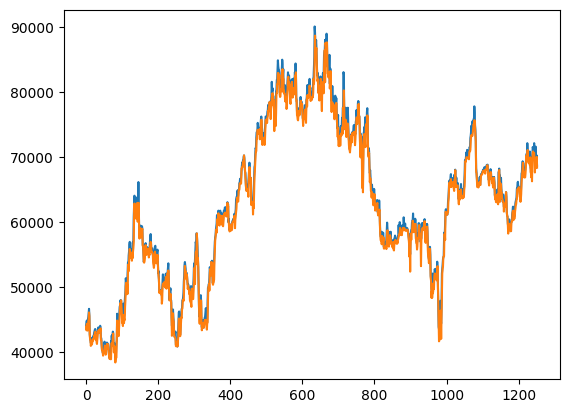

In [6]:
y = data[['Price']] # chuỗi thời gian cần dự báo (biến phụ thuộc)
X = data[['High']] # các biến độc lập
plt.plot(X)
plt.plot(y)
plt.show()

In [7]:
# chia train, test
train_size = int(0.7 * len(data))
test_size = len(data) - train_size

y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]

In [8]:
svr_poly = SVR(kernel='poly', C=1000, degree = 2)
svr_poly.fit(X_train, y_train)

svr_sigmoid = SVR(kernel='sigmoid')
svr_sigmoid.fit(X_train, y_train)

SVR(kernel='sigmoid')

In [9]:
# dự đoán giá đóng cửa của stock price trên tập kiểm tra
y_pred_poly = svr_poly.predict(X_test)
y_pred_poly = y_pred_poly.reshape(-1,1)

y_pred_sigmoid = svr_sigmoid.predict(X_test)
y_pred_sigmoid= y_pred_sigmoid.reshape(-1,1)

In [10]:
# tính toán độ chính xác của mô hình
mape_poly = mean_absolute_percentage_error(y_test, y_pred_poly) * 100
msle_poly = mean_squared_log_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(np.mean((y_pred_poly - y_test)**2))

mape_sigmoid = mean_absolute_percentage_error(y_test, y_pred_sigmoid) * 100
msle_sigmoid = mean_squared_log_error(y_test, y_pred_sigmoid)
rmse_sigmoid = np.sqrt(np.mean((y_pred_sigmoid - y_test)**2))

In [11]:
# in kết quả độ chính xác của mô hình
print("Poly MAPE:", mape_poly)
print("Poly MSLE:", msle_poly)
print("Poly RMSE:", rmse_poly)

print("Sigmoid MAPE:", mape_sigmoid)
print("Sigmoid MSLE:", msle_sigmoid)
print("Sigmoid RMSE:", rmse_sigmoid)

Poly MAPE: 2.0936023295264805
Poly MSLE: 0.0005506849661657477
Poly RMSE: 1415.8753084450568
Sigmoid MAPE: 9.183798450711759
Sigmoid MSLE: 0.012837731610060105
Sigmoid RMSE: 6846.015128244377


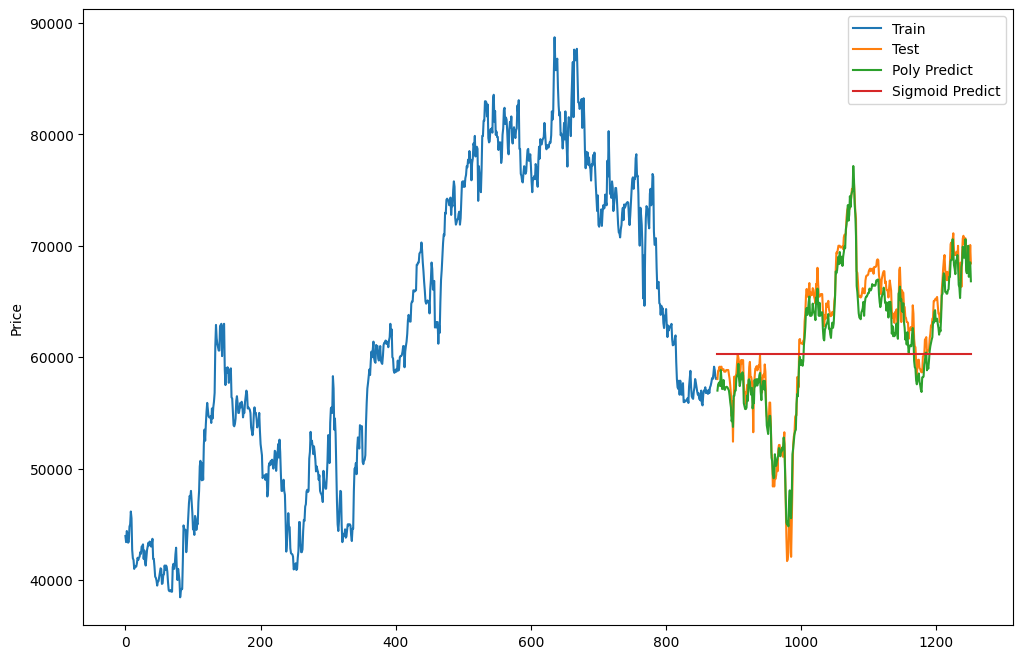

In [12]:
#vẽ mô hình
plt.figure(figsize=(12, 8))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred_poly, label='Poly Predict')
plt.plot(X_test.index, y_pred_sigmoid, label='Sigmoid Predict')
plt.ylabel('Price')
plt.legend()
plt.show()

In [13]:
#lấy giá trị Price của ngày cuối cùng trong dataset
last_index = data.index[-1]
last_row = data.tail(1)
last_data = last_row['Price'].values.reshape(-1,1)
last_data

array([[68421]], dtype=int64)

In [14]:
# tạo mảng chứa giá trị predict của 30 ngày tiếp theo
x_next_30_day_rbf = []
x_next_30_day_poly = []
x_next_30_day_sigmoid = []
index_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
# predict giá Price 30 ngày tiếp theo dựa vào giá Price của ngày trước đó

for i in range(30):
    x_pred_next = svr_poly.predict(last_data)
    x_next_30_day_poly.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

for i in range(30):
    x_pred_next = svr_sigmoid.predict(last_data)
    x_next_30_day_sigmoid.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

print("Kết quả dự đoán sử dụng Poly:", x_next_30_day_poly)
print("Kết quả dự đoán sử dụng Poly:", x_next_30_day_sigmoid)

Kết quả dự đoán sử dụng Poly: [array([66498.03364778]), array([64489.64629043]), array([62453.16464282]), array([60451.96146751]), array([58547.97546218]), array([56794.04223757]), array([55228.00108189]), array([53869.97149117]), array([52723.06374787]), array([51776.69609914]), array([51011.13871485]), array([50401.99181309]), array([49923.78165111]), array([49552.3885013]), array([49266.39542614]), array([49047.62047551]), array([48881.11995227]), array([48754.89990367]), array([48659.50152757]), array([48587.56214265]), array([48533.40624122]), array([48492.69059194]), array([48462.10953457]), array([48439.15733114]), array([48421.94037346]), array([48409.03090474]), array([48399.35425037]), array([48392.10253453]), array([48386.66902573]), array([48382.59838238])]
Kết quả dự đoán sử dụng Poly: [array([60250.00000011]), array([60250.]), array([60250.]), array([60250.]), array([60250.]), array([60250.]), array([60250.]), array([60250.]), array([60250.]), array([60250.]), array([6025

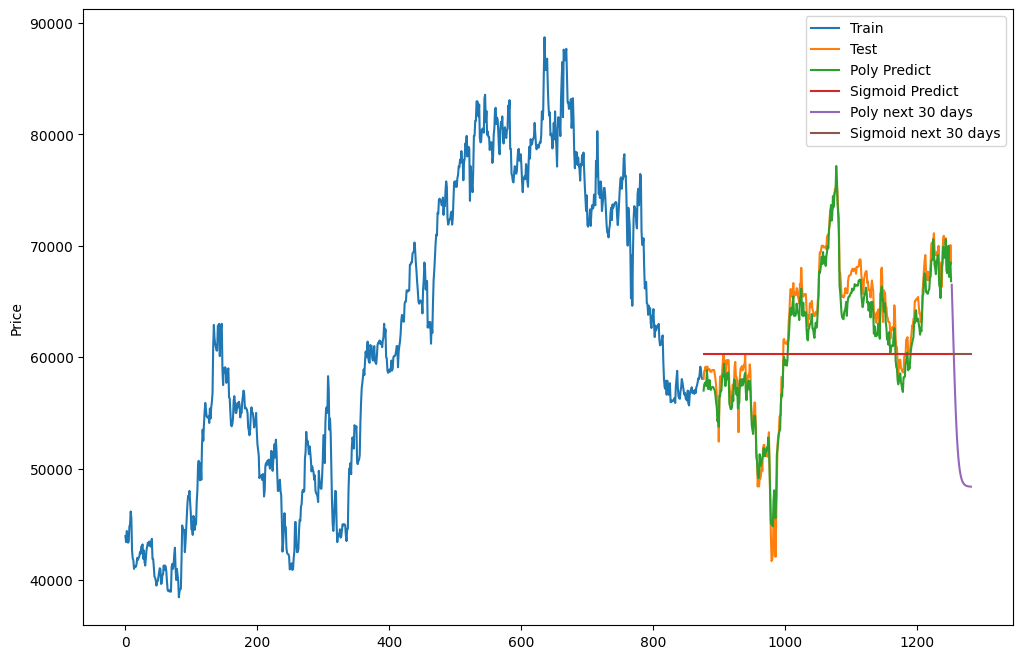

In [15]:
#vẽ mô hình
plt.figure(figsize=(12, 8))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred_poly, label='Poly Predict')
plt.plot(X_test.index, y_pred_sigmoid, label='Sigmoid Predict')

# Vẽ biểu đồ dự đoán sử dụng Poly
plt.plot(index_next_30_days,x_next_30_day_poly, label='Poly next 30 days')
# Vẽ biểu đồ dự đoán sử dụng Sigmoid
plt.plot(index_next_30_days,x_next_30_day_sigmoid, label='Sigmoid next 30 days')

plt.ylabel('Price')
plt.legend()
plt.show()